# Table of Contents

* [Chapter 1](#chapter1)
    * [Section 1.1](#section_1_1)
    * [Section 1.2](sSection_1_2)
        * [Section 1.2.1](#section_1_2_1)
        * [Section 1.2.2](#section_1_2_2)
        * [Section 1.2.3](#section_1_2_3)
* [Chapter 2](#chapter2)
    * [Section 2.1](#section_2_1)
    * [Section 2.2](#section_2_2)

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path

import seaborn as sns
from matplotlib import pyplot as plt
sns.set_theme(
    style="whitegrid",
    font_scale=2
);

# 0. Data loading <a class="anchor" id="section_1"></a>

In [4]:
DATA_FOLDER = Path('./data')
FRAME_LENGTH = 30
classes = [f.name for f in DATA_FOLDER.iterdir()]
classes

['running', 'stairs', 'walking', 'idle']

In [6]:
x_acc_cols = [f'acc_x_{i}' for i in range(FRAME_LENGTH)]
y_acc_cols = [f'acc_y_{i}' for i in range(FRAME_LENGTH)]
z_acc_cols = [f'acc_z_{i}' for i in range(FRAME_LENGTH)]
m_acc_cols = [f'acc_m_{i}' for i in range(FRAME_LENGTH)] # magnitude

frames = []
labels = []

for class_name in classes:
    class_folder = DATA_FOLDER / class_name
    for file in class_folder.iterdir():
        df = pd.read_csv(file)
        flat_frame = np.hstack([df['accelerometer_X'], df['accelerometer_Y'], df['accelerometer_Z']]).astype(float)
        frames.append(flat_frame)
        labels.append(class_name)
        
raw_data = pd.DataFrame(frames, columns = x_acc_cols+y_acc_cols+z_acc_cols)
raw_data = pd.concat([raw_data, pd.Series(labels, name='label')], axis=1)
raw_data.head(3)

,acc_x_0,acc_x_1,acc_x_2,acc_x_3,acc_x_4,acc_x_5,acc_x_6,acc_x_7,acc_x_8,acc_x_9,...,acc_z_21,acc_z_22,acc_z_23,acc_z_24,acc_z_25,acc_z_26,acc_z_27,acc_z_28,acc_z_29,label
0,2.667141,4.017470,22.357056,17.922995,-2.164358,9.749189,3.303998,-3.275268,5.252879,21.490355,...,13.493721,-2.001553,16.668432,9.208099,-7.187393,12.430696,-8.939949,1.470040,10.807426,running
1,10.745177,3.744532,0.766145,23.956383,-0.454898,-3.481169,3.572149,7.527370,-10.793061,9.481039,...,11.468226,-0.952892,-0.943315,-0.416591,0.483629,0.363919,1.699883,3.390190,-1.407790,running
2,22.031445,3.600880,-0.354342,8.245631,18.641254,4.381389,26.499025,4.003105,3.284845,2.231396,...,0.565032,-4.079719,-3.677494,4.596867,-0.550666,-6.019023,-1.139640,-2.164358,-3.016694,running


In [7]:
raw_data.shape

(6462, 91)

# 1. EDA

In [8]:
raw_data.label.value_counts()

running    3408
walking    1850
idle       1039
stairs      165
Name: label, dtype: int64

# 2. Setup validation and baselines 

## 2.1 StratifiedKFold

In [9]:
from sklearn.model_selection import StratifiedKFold


kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [11]:
X = raw_data['acc_x_0']
y = raw_data['label']

for i, (_, valid_ix) in enumerate(kfold.split(X, y)):
    y_valid = y.loc[valid_ix]
    value_counts = y_valid.value_counts()
    print(f'split#{i}, we have {value_counts.stairs} stairs, {value_counts.running} running samples')
#     print(    (y_valid == 'stairs').index)

split#0, we have 33 stairs, 682 running samples
split#1, we have 33 stairs, 682 running samples
split#2, we have 33 stairs, 682 running samples
split#3, we have 33 stairs, 681 running samples
split#4, we have 33 stairs, 681 running samples


## 2.2 Magnitude of acceleration

TODO

In [12]:
am_matrix = np.sqrt(raw_data[x_acc_cols].values**2 + raw_data[y_acc_cols].values**2 + raw_data[z_acc_cols].values**2)
raw_data = pd.concat([raw_data, pd.DataFrame(am_matrix, columns=m_acc_cols)], axis=1)

In [13]:
sample = raw_data.iloc[42]
assert np.allclose((sample.acc_x_0**2 + sample.acc_y_0**2 + sample.acc_z_0**2 ),  sample.acc_m_0**2)

## 2.3 mean of TODO

In [14]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(classes)

LabelEncoder()

In [15]:
feature_df = raw_data[['label']].copy()
feature_df['encoded_label'] = le.transform(feature_df['label'])

In [16]:
def gen_feature_mean(ts):
    return np.mean(ts, axis=1)

feature_df['mean_x'] = gen_feature_mean(raw_data[x_acc_cols])
feature_df['mean_y'] = gen_feature_mean(raw_data[y_acc_cols])
feature_df['mean_z'] = gen_feature_mean(raw_data[z_acc_cols])
feature_df['mean_m'] = gen_feature_mean(raw_data[m_acc_cols])
mean_features = ['mean_x', 'mean_y', 'mean_z', 'mean_m']

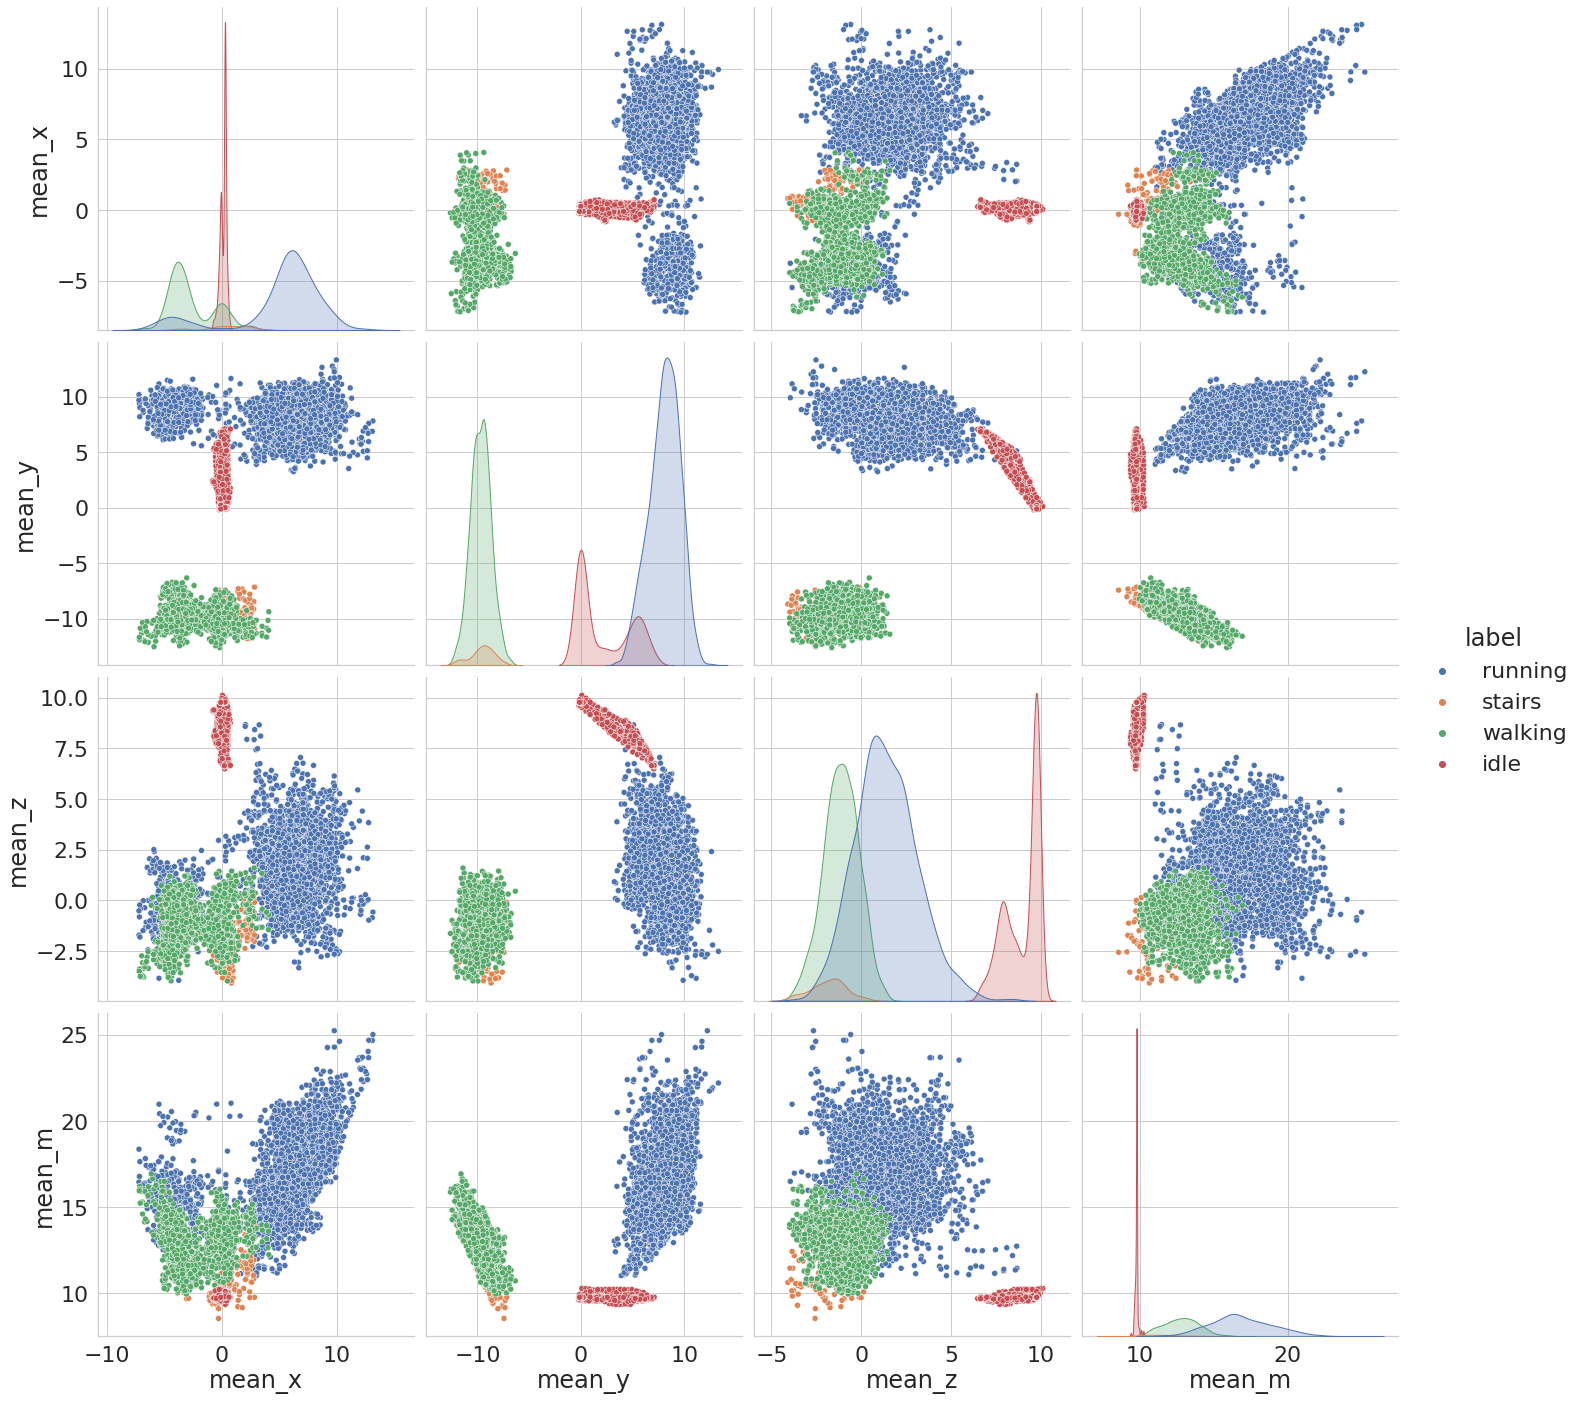

In [17]:
sns.pairplot(data=feature_df[mean_features + ['label']], hue='label', height=5);

## Baselines

In [24]:
from sklearn import svm
from sklearn import linear_model
from sklearn.metrics import f1_score, confusion_matrix, multilabel_confusion_matrix, accuracy_score

In [26]:
X = feature_df[mean_features]
y = feature_df['label']
f_scores = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
    cls = linear_model.LogisticRegression(max_iter=2_000)
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    f_scores.append(accuracy_score(y_valid, y_pred))
    print(confusion_matrix(y_valid, y_pred))
    
print(f'Accuracy mean: {round(np.mean(f_scores), 2)}, std: {round(np.std(f_scores), 2)}')

[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  19  14]
 [  0   0   1 369]]
[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  22  11]
 [  0   0   5 365]]
[[207   0   0   0]
 [  0 682   0   0]
 [  0   0  24   9]
 [  0   0   1 369]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  19  14]
 [  0   0   5 365]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  26   7]
 [  0   0   3 367]]
Accuracy mean: 0.99, std: 0.0


In [29]:
cls = linear_model.LogisticRegression(max_iter=2_000)
cls.fit(X_train, y_train)
y_pred = cls.predict(X_valid)

In [30]:
cls.coef_

array([[-1.11693219,  1.26996541,  2.64989393],
       [ 0.8761829 ,  0.48161475, -0.95354791],
       [ 0.52349184, -0.55169286, -1.38645113],
       [-0.28274254, -1.19988731, -0.30989489]])

In [27]:
mean_features

['mean_x', 'mean_y', 'mean_z', 'mean_m']

In [28]:
X = feature_df[['mean_x', 'mean_y', 'mean_z']]
y = feature_df['label']
f_scores = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
    cls = linear_model.LogisticRegression(max_iter=2_000)
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    f_scores.append(accuracy_score(y_valid, y_pred))
    print(confusion_matrix(y_valid, y_pred))
    
print(f'Accuracy mean: {round(np.mean(f_scores), 2)}, std: {round(np.std(f_scores), 2)}')

[[208   0   0   0]
 [  3 679   0   0]
 [  0   0  13  20]
 [  0   0   5 365]]
[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  11  22]
 [  0   0   2 368]]
[[207   0   0   0]
 [  0 682   0   0]
 [  0   0  12  21]
 [  0   0   6 364]]
[[208   0   0   0]
 [  2 679   0   0]
 [  0   0  14  19]
 [  0   0  12 358]]
[[208   0   0   0]
 [  1 680   0   0]
 [  0   0  14  19]
 [  0   0   7 363]]
Accuracy mean: 0.98, std: 0.0


In [23]:
X = feature_df[mean_features]
y = feature_df['label']
f_scores = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
    cls = svm.SVC()
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    f_scores.append(accuracy_score(y_valid, y_pred))
    print(confusion_matrix(y_valid, y_pred))
    
print(f'Accuracy mean: {round(np.mean(f_scores), 2)}, std: {round(np.std(f_scores), 2)}')

[[208   0   0   0]
 [  2 680   0   0]
 [  0   0  13  20]
 [  0   0   0 370]]
[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  14  19]
 [  0   0   0 370]]
[[207   0   0   0]
 [  0 682   0   0]
 [  0   0  12  21]
 [  0   0   0 370]]
[[208   0   0   0]
 [  1 680   0   0]
 [  0   0  15  18]
 [  0   0   1 369]]
[[208   0   0   0]
 [  1 680   0   0]
 [  0   0  11  22]
 [  0   0   1 369]]
Accuracy mean: 0.98, std: 0.0
